In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
from konlpy.tag import Kkma
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS # 불용어 사전 
import numpy as np

%matplotlib inline

#### 스크롤을 맨 아래까지 내려주는 함수

In [2]:
def scroll_down(driver):
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight") 
    while True: 
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);") 
        time.sleep(3.0) 
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight") 
        if new_page_height == last_page_height: 
            break 
        last_page_height = new_page_height

In [3]:
# 영상 시간 split용
# s example: '2019. 1. 23'

def split_date(s):
    ymd = s.split('. ')
    return ymd

#### '유니클로'를 검색한 url의 link를 수집함

In [4]:
url = "https://www.youtube.com/results?search_query=유니클로&sp=CAI%253D"
# youtube에서 유니클로를 검색한 글이 시간순으로 정렬되어 있는 url
driver = webdriver.Chrome('C:\chromedriver')
driver.get(url)
scroll_down(driver)

# 관련 link 크롤링
links = list()
for link in driver.find_elements_by_xpath('//*[@id="video-title"]'):
    x = link.get_attribute('href')
    # 빈 link는 list에 저장하지 않음
    if x:
        links.append(x)

#### 위에서 받은 link를 타고 들어가서, 댓글 내용과 시간을 크롤링하는 코드 

In [6]:
data = list()  # 전체 댓글 리스트
# 댓글 읽어오기
for i in links:
    driver.get("{}".format(i)) # 링크를 get 하는 코드 
    scroll_down(driver) # 각 페이지를 들어가서 스크롤을 내리는 함수 
    
    # 해당 영상(i)의 댓글 내용 
    comments = driver.find_elements_by_id("content-text") 
    # 댓글 시간
    comment_date = driver.find_element_by_xpath('//*[@id="date"]/yt-formatted-string')
    date = comment_date.text
    
    # 실시간 스트리밍/최초 공개 등의 텍스트 처리 - date에서 20
    date = date[date.find('20'):]
    ymd = split_date(date)

    # 너무 오래된 댓글은 삭제
    if ymd[0] == '2018' and int(ymd[1]) < 7:
        break
    
    for comment in comments:
        comment_one = [0 for i in range(2)] # 범위지정 빈 리스트를 만들어 주기. 
        comment_one[0] = date
        comment_one[1] = comment.text
        data.append(comment_one)

In [7]:
data[len(data)-1] # 데이터 잘 들어왔나 확인용..ㅎ

['2018. 7. 2.', '어제 생방에서 했던 내용이네요 저도 한번 h&m 도전?..']

#### pandas를 이용해서 csv파일로 저장하기. 
- 위의 데이터를 저장하는 것

In [8]:
df = pd.DataFrame(data, columns=['date', 'comment'])
df.to_csv("comment_data.csv",sep=',',index= False, compression= "infer")

In [ ]:
data = pd.read_csv("comment_data.csv") 

#### 위에서 받은 list를 기간에 따라서 나누어서 list를 넣어놓기
#### 그 후, 꼬꼬마로 명사만 추출함. 

- data는 리스트이기 때문에, for 구문을 돌려서, 꼬꼬마 해줌. 
- 우리 프로젝트는 4개의 기간으로 나누기 때문에, 리스트를 4개로 나눔 
- split_data()함수를 사용하여 기간을 4개로 함. 
- 이후, extend를 사용해서 명사들을 각 리스트에 넣어서 하나의 리스트로만듦.

In [ ]:
# 명사 추출하는 코드
kkma = Kkma()
noun_list_01 = [] # 2020.01 ~
noun_list_02 = [] # 2019.07 ~ 2019.12
noun_list_03 = [] # 2019.01 ~ 2019.06
noun_list_04 = [] # 2018.07 ~ 2018.12
for com in range(len(data)):
    noun = kkma.nouns(str(data.iloc[com].values[1])) # arry 를 txt로 변경 
    ymd = split_date(data.iloc[com].values[0])
    con_nouns = filter(lambda word : len(word)>1 , noun)
    if ymd[0] == '2020':
        noun_list_01.extend(con_nouns)
    elif ymd[0] == '2019' and int(ymd[1]) >= 7:
        noun_list_02.extend(con_nouns)
    elif ymd[0] == '2019' and int(ymd[1]) < 7:
        noun_list_03.extend(con_nouns)
    else:
        noun_list_04.extend(con_nouns)

In [ ]:
len(noun_list_04)  # 갯수 확인

In [ ]:
# 혹시 모르니, noun 데이터 저장  # txt 이름이랑 리스트 이름 바꿔주세요
f = open('noun_list_01.txt', 'w', encoding='utf8')
for i in noun_list_01:
    f.write("{},".format(i)) 

####  워드 크라우드 그리는 코드

In [46]:
stop_w = STOPWORDS | \
set(["유니", "진짜", "제가", "설명", "사람", "하나", "어디", "이번", "인간", \
     "이제", "무엇", "계속", "한번", "니들", "생각", "주세", "그것", "때문", \
    "이것", "영상", "컨텐츠"])

In [47]:
def word_show(noun_list):
    result= " ".join(noun_list)
    result_w= WordCloud(background_color="white",
                             max_words=1000, stopwords = stop_word,
                             font_path="C:\Windows/Fonts/Malgun.ttf",
                             random_state=42, relative_scaling=0.2)
    result_w.generate(result)
    plt.figure(figsize=(15,10))
    plt.imshow(result_w, interpolation="bilinear") 
    plt.axis("off")  
    
    return plt.show()

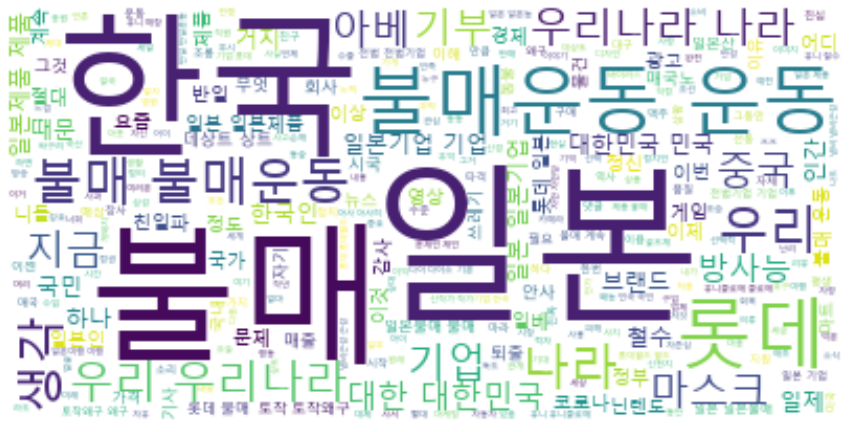

In [48]:
# 2020 상반기 (2020.01 ~ 현재) # wordcloud용 데이터 만들어서

word_show(noun_list_01)

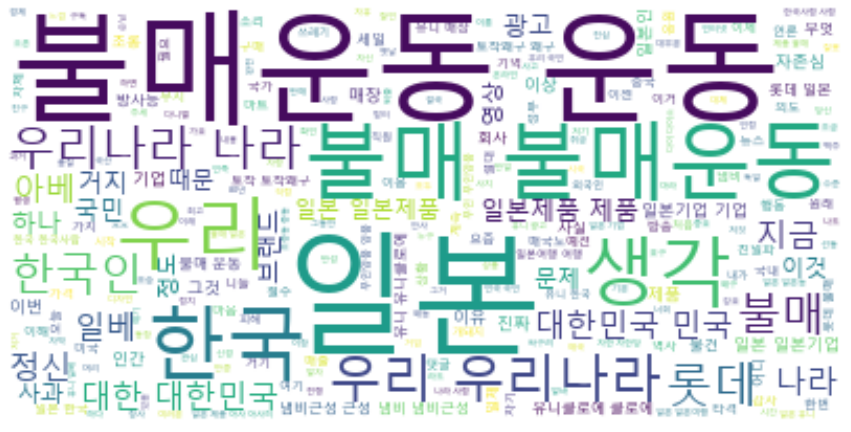

In [49]:
word_show(noun_list_02) # 2019 하반기 (2019.07 ~ 2019.12)

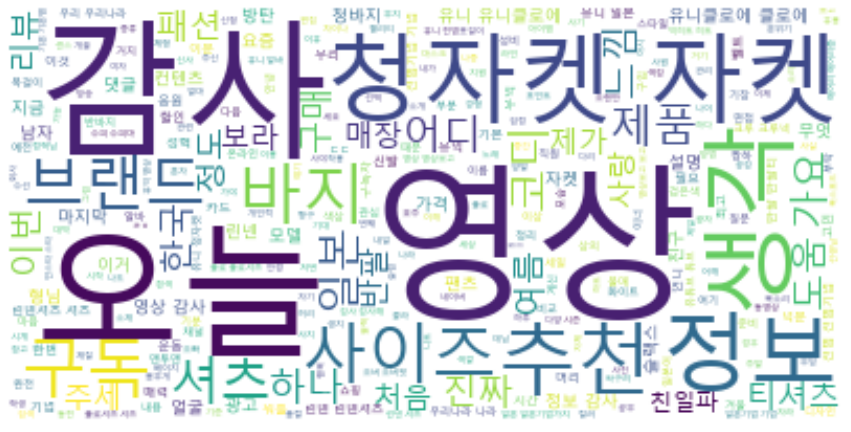

In [50]:
word_show(noun_list_03) # 2019 상반기 (2019.01 ~ 2019.06)

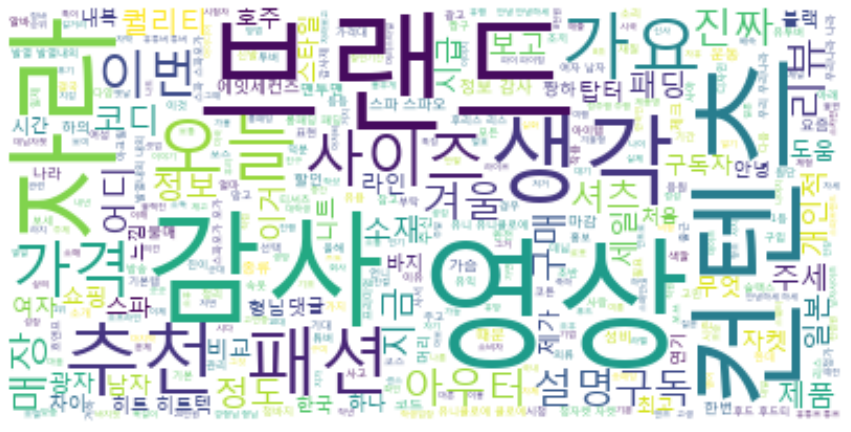

In [51]:
word_show(noun_list_04) # 2018 하반기 (2018.07 ~ 2018.12)